<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cifar-10/resized/15*15/cifar10_15_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [5]:
!unzip /content/drive/My\ Drive/Gabor\ Dataset/cifar10.zip -d cifar10

Streaming output truncated to the last 5000 lines.
  inflating: cifar10/cifar10/test/ship.1.jpg  
  inflating: cifar10/cifar10/test/airplane.10.jpg  
  inflating: cifar10/cifar10/test/horse.13.jpg  
  inflating: cifar10/cifar10/test/truck.38.jpg  
  inflating: cifar10/cifar10/test/frog.43.jpg  
  inflating: cifar10/cifar10/test/horse.83.jpg  
  inflating: cifar10/cifar10/test/cat.91.jpg  
  inflating: cifar10/cifar10/test/frog.102.jpg  
  inflating: cifar10/cifar10/test/frog.112.jpg  
  inflating: cifar10/cifar10/test/bird.138.jpg  
  inflating: cifar10/cifar10/test/frog.142.jpg  
  inflating: cifar10/cifar10/test/horse.145.jpg  
  inflating: cifar10/cifar10/test/frog.146.jpg  
  inflating: cifar10/cifar10/test/frog.163.jpg  
  inflating: cifar10/cifar10/test/dog.178.jpg  
  inflating: cifar10/cifar10/test/airplane.180.jpg  
  inflating: cifar10/cifar10/test/bird.182.jpg  
  inflating: cifar10/cifar10/test/cat.184.jpg  
  inflating: cifar10/cifar10/test/deer.188.jpg  
  inflating: cifa

In [6]:
ITERATION = 1
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = 42
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
# TRAIN_DIR = "cifar10/cifar10/train/"
# TEST_DIR = "cifar10/cifar10/test/"
TEST_DIR = "cifar10/cifar10/train/"
TRAIN_DIR = "cifar10/cifar10/test/"

In [7]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

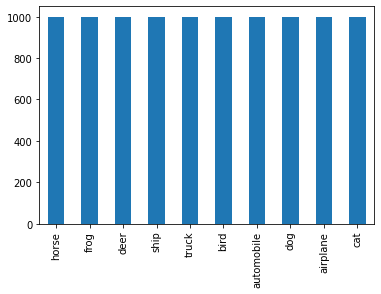

In [9]:
train_df['category'].value_counts().plot.bar()

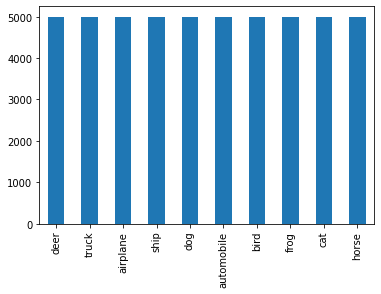

In [10]:
validate_df['category'].value_counts().plot.bar()

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 10000 validated image filenames belonging to 10 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 50000 validated image filenames belonging to 10 classes.


In [13]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      21632     
_________________________________________________________________
batch_normalization (BatchNo (None, 242, 242, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = RMSprop(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
312/312 [==============================] - 128s 410ms/step - loss: 2.4530 - accuracy: 0.2795 - val_loss: 2.2346 - val_accuracy: 0.2515
Epoch 2/1000
312/312 [==============================] - 128s 410ms/step - loss: 1.8970 - accuracy: 0.3614 - val_loss: 2.9971 - val_accuracy: 0.1690
Epoch 3/1000
312/312 [==============================] - 126s 405ms/step - loss: 1.6582 - accuracy: 0.4187 - val_loss: 1.8451 - val_accuracy: 0.3842
Epoch 4/1000
312/312 [==============================] - 125s 400ms/step - loss: 1.5072 - accuracy: 0.4667 - val_loss: 1.6803 - val_accuracy: 0.4300
Epoch 5/1000
312/312 [==============================] - 126s 404ms/step - loss: 1.4247 - accuracy: 0.4931 - val_loss: 1.7168 - val_accuracy: 0.4203
Epoch 6/1000
312/312 [==============================] - 125s 402ms/step - loss: 1.3351 - accuracy: 0.5239 - val_loss: 1.6595 - val_accuracy: 0.4325
Epoch 7/1000
312/312 [==============================] - 123s 393ms/step - loss: 1.2696 - accuracy: 0.5500 - val_

In [15]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 1265.304366038
Finish time = 6949.532699877
Training time = 5684.228333839


In [16]:
import pickle

with open('cifar10-{}-history-kernel-{}.p'.format(ITERATION, GABOR_HEIGHT), 'wb') as fp:
  pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

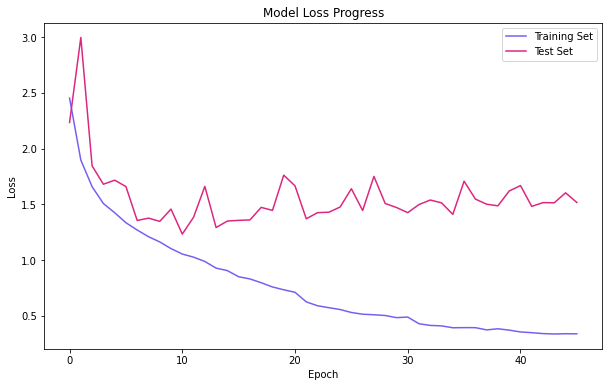

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cifar10-{}-loss-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

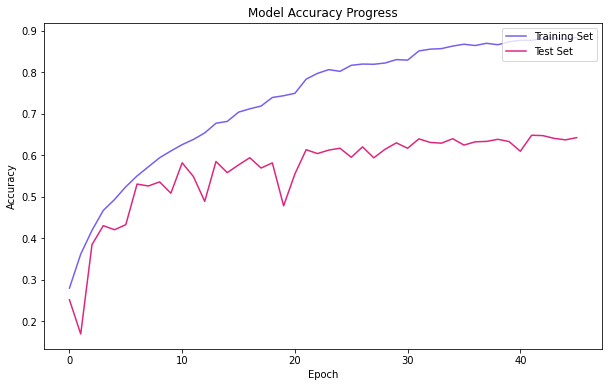

In [18]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cifar10-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

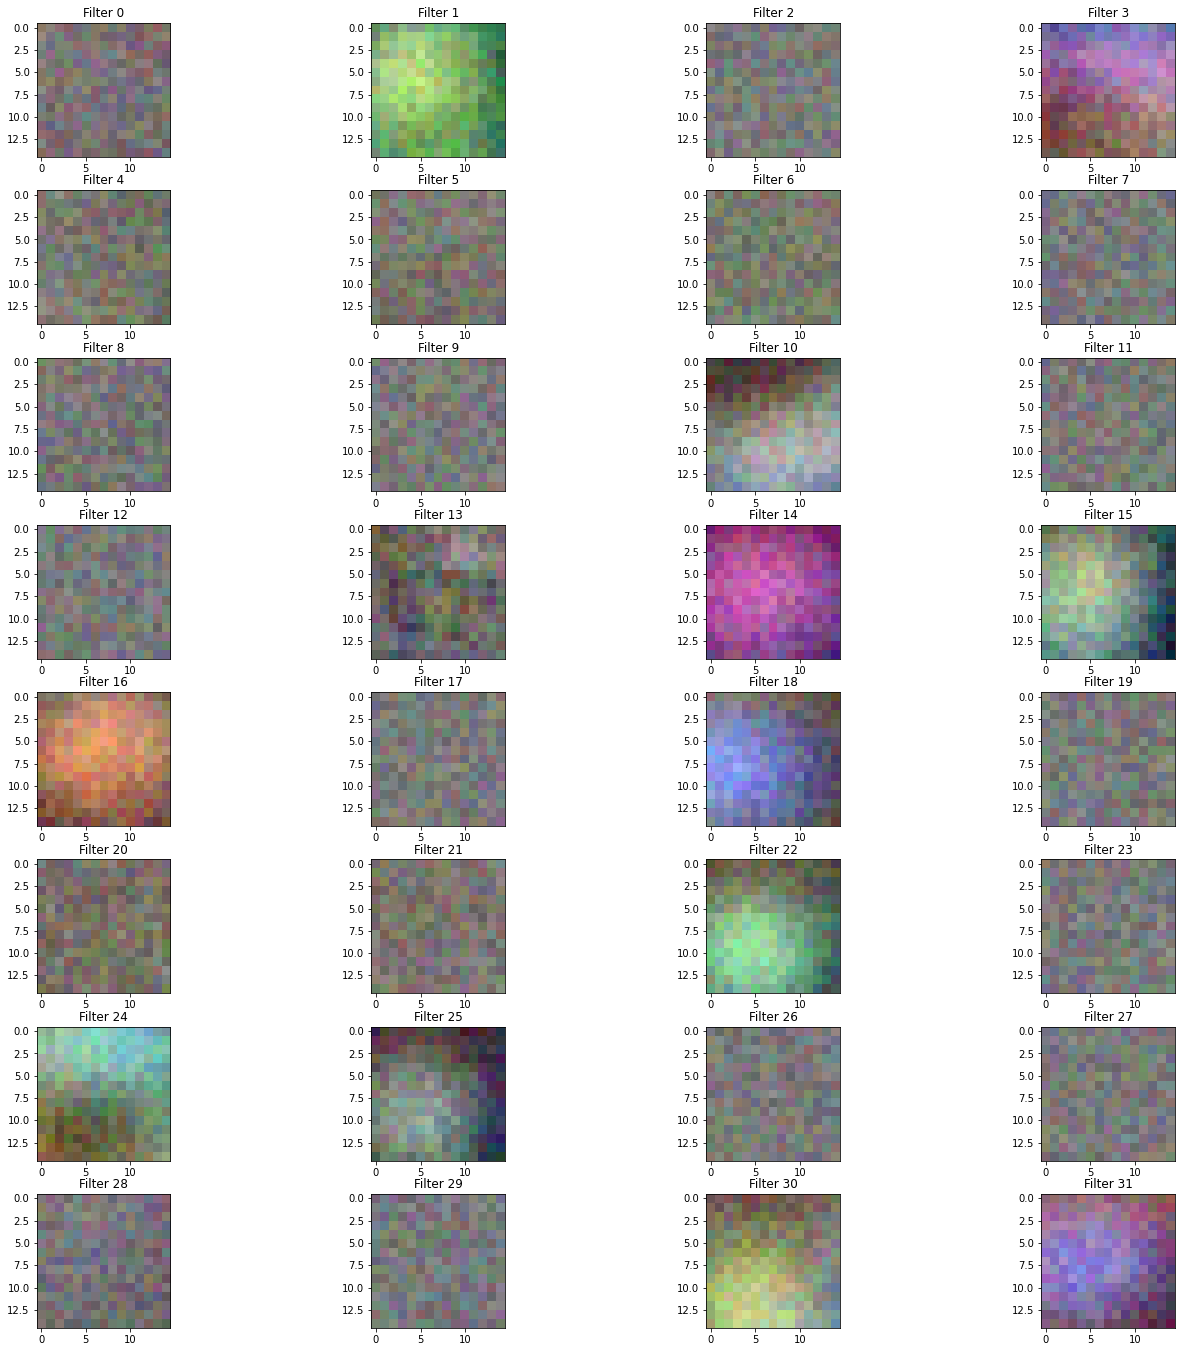

In [19]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("cifar10-{}-filters-kernel-{}.png".format(ITERATION, GABOR_WIDTH), bbox_inches='tight', dpi=350)

-0.13475469 0.140082


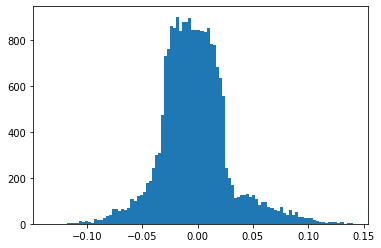

In [20]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

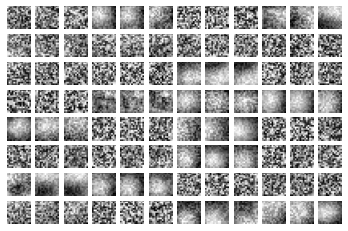

In [21]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("cifar10-{}-channelwise-filters-kernel-{}.png".format(ITERATION, GABOR_WIDTH), bbox_inches='tight', dpi=350)